# Анализ данных о пользователях сервиса аренды самокатов и их поездках

### Постановка задачи

#### Цели исследования:
- Проверка гипотез (п.6).
- Ответы на вопросы (п.7).
- Ответ на главный вопрос: являются ли пользователи с платной подпиской более выгодными для компании.

#### Этапы исследования:
1. Изучение общей информации о датафреймах.
2. Предобработка данных:
    - обработка пропусков
    - обработка дубликатов
    - обработка аномалий
    - округление данных
    - преобразование типов данных
    - создание дополнительного столбца с номером месяца
3. Исследовательский анализ (описание и визуализация общей информации о пользователях и поездках):
    - частота встречаемости городов
    - соотношение пользователей с подпиской и без подписки
    - возраст пользователей
    - расстояние, которое пользователь преодолел за одну поездку
    - продолжительность поездок
4. Объединение данных
    - Объединение данных о пользователях, поездках и подписках в один датафрейм.
    - Разделение нового датафрейма на два:
        - c данными о пользователях без подписки
        - с данными о пользователях с подпиской
    - Визуализация информации о расстоянии и времени поездок для пользователей обеих категорий.
5. Подсчёт выручки. (создание датафрейма о поездках для каждого пользователя за каждый месяц со следующими агрегированными данными):
    - суммарное расстояние
    - количество поездок
    - суммарное время поездок
    - помесячная выручка, которую принёс пользователь
6. Проверка гипотез:
    - Тратят ли пользователи с подпиской больше времени на поездки?
    - Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?
    - Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?
7. Ответы на вопросы: 
    - Нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. Какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5%. Подобрать параметры распределения, описывающего эту ситуацию, построить график распределения.
    - Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 11 млн уведомлений. С помощью аппроксимации построить примерный график распределения и оценить вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

#### Данные для исследования:

1. Пользователи - users_go.csv
    - user_id: уникальный идентификатор пользователя
    - name: имя пользователя
    - age: возраст
    - city: город
    - subscription_type: тип подписки (free, ultra)
2. Поездки - rides_go.csv
    - user_id: уникальный идентификатор пользователя
    - distance: расстояние, которое пользователь проехал в текущей сессии (в метрах)
    - duration: продолжительность сессии (в минутах) - время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
    - date: дата совершения поездки
3. Подписки - subscriptions_go.csv	
    - subscription_type: тип подписки
    - minute_price: стоимость одной минуты поездки по данной подписке
    - start_ride_price: стоимость начала поездки
    - subscription_fee: стоимость ежемесячного платежа

### Загрузка данных и изучение общей информации

#### Загрузка библиотек и файлов, установка базовых настроек

In [1]:
# Загружаем все необходимые библиотеки
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats as st

# Убираем необязательные предупреждения
import warnings
warnings.filterwarnings('ignore')

# Настраиваем полное отображение всех строк таблицы
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
# Задаём стандартне параметры для графиков
plt.rcParams['figure.figsize'] = 9,3
plt.rcParams.update({'font.size':'12'})

In [3]:
# Создаём датафреймы из файлов
users = pd.read_csv('/datasets/users_go.csv')
rides = pd.read_csv('/datasets/rides_go.csv')
subs = pd.read_csv('/datasets/subscriptions_go.csv')

#### Датафрейм users

In [4]:
users.head(3)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra


In [5]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [6]:
# Посмотрим все уникальные значения типа подписки
users['subscription_type'].unique()

array(['ultra', 'free'], dtype=object)

В датафрейме 5 колонок и 1565 строк, пропусков нет. Тип подписки представлен в строковом виде? хотя имеет всего два уникальных значения (есть платная подписка / нет платной подписки).

#### Датафрейм rides

In [7]:
rides.head(3)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20


In [8]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


В датафрейме 4 колоноки и 18068 строк, пропусков нет. Колонка с датой имеет строковый тип данных. Значения в столбцах с расстоянием и временем поездки не округлённые.

#### Датафрейм subs (subscriptions)

In [9]:
subs

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [10]:
subs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


В датафрейме 5 колонок и всего 2 строки, пропусков нет. Здесь представлена информация о тарифах сервиса (первая строка - цены без подписки, вторая строка - цены с подпиской).

### Предобработка данных

#### Обработка дубликатов

##### Поиск явных дубликатов в датафрейме users

In [11]:
# Смотрим количество явных дубликатов
users.duplicated().sum()

31

Посмотрим примеры дубликатов:

In [12]:
# Выводим несколько дубликатов на экран
users[users.duplicated()].sample(3)

,user_id,name,age,city,subscription_type
1564,1045,Артемий,28,Ростов-на-Дону,free
1554,1198,Демид,29,Ростов-на-Дону,free
1537,403,Полина,19,Сочи,ultra


In [13]:
# Удаляем явные дубликаты
users = users.drop_duplicates()
# Смотрим количество явных дубликатов
users.duplicated().sum()

0

Была удалена 31 строка с дубликатами. Теперь проверим дубликаты отдельно по столбцу user_id

In [14]:
# Смотрим количество явных дубликатов отдельно в столбце user_id
users['user_id'].duplicated().sum()

0

##### Поиск неявных дубликатов в столбце city

In [15]:
# Смотрим полный список городов, представленных в датафрейме
users['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

В датафрейме представлено всего 8 городов, дубликатов нет.

##### Поиск явных дубликатов в датафрейме rides

In [16]:
# Смотрим количество явных дубликатов
rides.duplicated().sum()

0

Дубликатов не выявлено.

##### Итоги обработки дубликатов

Из датафрейма users был удалён 31 явный дубликат. Других дубликатов выявлено не было.

#### Обработка аномалий

##### Проверка что столбец user_id в датафреймах users и rides имеет одинаковые значения

In [17]:
# Проверяем, что все значения столбца user_id из таблицы users
# есть в столбце user_id из таблицы rides и наоборот
print(users['user_id'].isin(rides['user_id']).all())
print(rides['user_id'].isin(users['user_id']).all())

True
True


В датафреймах нет пользователей, у которых нет поездок, и нет поездок, для которых не определены пользователи.

##### Датафрейм users, столбец users_age

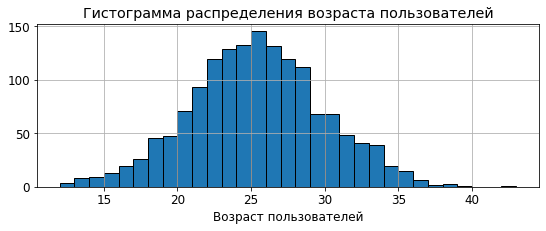

In [18]:
# Посчитаем возрастной диапазон пользователей
age_range = users['age'].max() - users['age'].min()
# Строим гистограмму
users['age'].hist(bins=age_range, linewidth=1.0, edgecolor='k')
plt.title('Гистограмма распределения возраста пользователей')
plt.xlabel('Возраст пользователей')
plt.show()

Возраст пользователей от 12 до 43 лет, аномальных значений в данном столбце нет.

##### Датафрейм rides, столбец distance

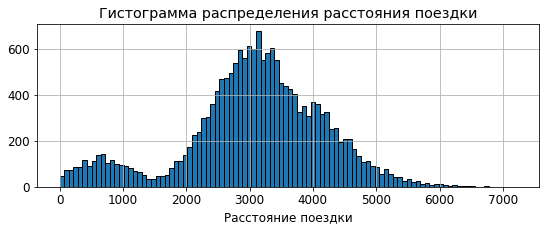

In [19]:
# Строим гистограмму
rides['distance'].hist(bins=100, linewidth=1.0, edgecolor='k')
plt.title('Гистограмма распределения расстояния поездки')
plt.xlabel('Расстояние поездки')
plt.show()

Аномальных значений нет.

##### Датафрейм rides, столбец duration

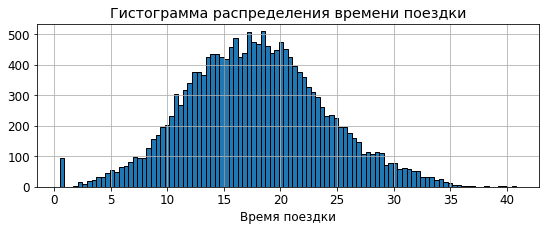

In [20]:
# Строим гистограмму
rides['duration'].hist(bins=100, linewidth=1.0, edgecolor='k')
plt.title('Гистограмма распределения времени поездки')
plt.xlabel('Время поездки')
plt.show()

На гистограмма показано нормальное распределение. Максимальные и минимальные значения не выходят за пределы допустимых, но на 30 секундах есть странный пик. Рассмотрим эти строки более детально.

In [21]:
# Считаем кол-во поездок, которые длились ровно 30 секунд
print('Всего тридцатисекундных поездок: ', len(rides[rides['duration'] == 0.5]))
print('Среднее расстояние:', round(rides['distance'][rides['duration'] == 0.5].mean()), 'км')

Всего тридцатисекундных поездок:  95
Среднее расстояние: 5113 км


In [22]:
# Посмотрим все поездки, которые длились ровно 30 секунд
rides[rides['duration'] == 0.5].sample(3)

,user_id,distance,duration,date
14342,1268,4177.139336,0.5,2021-06-09
15492,1355,5913.033578,0.5,2021-01-16
7791,792,5353.189287,0.5,2021-11-06


Средняя скорость таких поездок больше 600 км/час! Скорее всего произошла техническая ошибка. Поскольку таких строк мало, а возможности восстановить реальное время поездки у нас нет, удалим их из датафрейма.

In [23]:
# Создаём массив с индексами строк, которые нужно удалить
index_del_arr = rides[rides['duration'] == 0.5].index.tolist()
# Удаляем строки
rides = rides.drop(index_del_arr)
# Проверяем, что строк больше нет
len(rides[rides['duration'] == 0.5])

0

Проверим, что мы не удалили все поездки у какого-либо пользователя (т.е. в датафрейме users не появилось пользователей, у которых нет ни одной поездки в датафрейме rides).

In [24]:
# Проверяем, что у каждого пользователя из датафрейма users есть поездки
# есть поездки в датафрейме rides
users['user_id'].isin(rides['user_id']).all()

True

##### Поиск аномальных поездок по скорости

Возможно есть и другие поездки, скорость которых слишком высока. Создадим дополнительный столбец speed со скоростью поездок, в километрах в час.

In [25]:
rides['speed'] = round(rides['distance'] / rides['duration'] * (60 / 1000), 2)
rides.sample(1)

,user_id,distance,duration,date,speed
7941,805,4320.713788,23.970878,2021-04-10,10.81


Построим гистограмму:

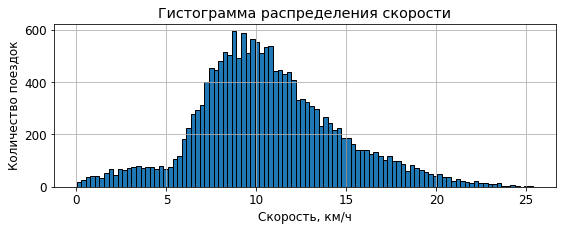

In [26]:
# Строим гистограмму
rides['speed'].hist(bins=100, linewidth=1.0, edgecolor='k')
plt.title('Гистограмма распределения скорости')
plt.xlabel('Скорость, км/ч')
plt.ylabel('Количество поездок')
plt.show()

Аномалий нет. 

Оставим столбец с рассчитанной скоростью, возможно он ещё пригодится.

##### Итоги обработки аномалий

В датафрейме rides было вывлено 95 аномальных знячений (время поездок ровно 30 секунд, при расстоянии несколько километров). Данные строки были удалены из датафрейма. Других аномальных значений выявлено не было.

#### Округление данных

Для данного исследования, излишняя точность ни к чему, но работать с данными будет удобнее, если их округлить. Округлм метры до целых значений. Минуты переведём в секунды и также округлим до целых.

In [27]:
# Округляем данные
rides['distance'] = round(rides['distance'])
rides['duration'] = np.ceil(rides['duration'])
rides.sample(3)

,user_id,distance,duration,date,speed
17364,1486,4028.0,13.0,2021-06-29,19.66
7756,790,3293.0,21.0,2021-03-23,9.68
9264,905,3667.0,17.0,2021-11-15,13.56


#### Преобразование типов данных

##### Меняем название и тип столбецов с информацией о подписке на bool

В датафрейме users изменим название столбца "subscription_type" на "subscription", и изменим тип данных на bool: пользователям с платной подпиской присвоим значение True, пользователям без платной подписки False.

In [28]:
# Меняем название столбца
users = users.rename(columns={'subscription_type': 'subscription'})
users.sample()

,user_id,name,age,city,subscription
690,691,Сергей,30,Сочи,ultra


In [29]:
# Меняем значения на True и False
users['subscription'][users['subscription'] == 'free'] = False
users['subscription'][users['subscription'] == 'ultra'] = True
# Меняем тип столбца на bool
users['subscription'] = users['subscription'].astype(bool)
users.dtypes['subscription']

dtype('bool')

То же самое сделаем с датафреймом subs.

In [30]:
subs = subs.rename(columns={'subscription_type': 'subscription'})
subs

,subscription,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [31]:
# Меняем значения на True и False
subs['subscription'][subs['subscription'] == 'free'] = False
subs['subscription'][subs['subscription'] == 'ultra'] = True
# Меняем тип столбца на bool
subs['subscription'] = subs['subscription'].astype(bool)
subs.dtypes['subscription']

dtype('bool')

##### Меняем тип столбцов с временем и расстоянием на int

In [32]:
# Меняем тип с float на int
rides['distance'] = rides['distance'].astype(int)
rides['duration'] = rides['duration'].astype(int)
rides.dtypes

user_id       int64
distance      int64
duration      int64
date         object
speed       float64
dtype: object

##### Приведём дату к формату datetime

In [33]:
rides['date'].sample()

8436    2021-09-23
Name: date, dtype: object

In [34]:
# Меняем формат даты
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%dT')
# Проверяем что формат даты был изменён корректно
rides['date'].sample()

813   2021-04-01
Name: date, dtype: datetime64[ns]

#### Создание столбца с номером месяца

Проверить за какой период у нас данные (чтобы данные за несколько лет не склеились при агрегации по месяцам).

In [35]:
# Посмотрим за какой период наша выборка
print('Минимальная дата: ', rides['date'].min())
print('Максимальная дата: ', rides['date'].max())

Минимальная дата:  2021-01-01 00:00:00
Максимальная дата:  2021-12-30 00:00:00


В выборке представлены данные только за 2021 год.

Создадим столбец с номером месяца:

In [36]:
# Добавляем столбец с номером месяца
rides['month'] = rides['date'].dt.month
rides.sample(1)

,user_id,distance,duration,date,speed,month
6660,711,2971,24,2021-01-03,7.62,1


#### Итоги предобработки данных

Была выполнена полная предобработка данных:
- была выполнена проверка на отсутствие пропусков
- были удалены дубликаты
- были удалены аномальные значения
- было выполнено округление для дробных значений
- типы данных были преведены к нужному виду
- был создан дополнительный столбец с номером месяца

Датафреймы готовы к дальнейшей работе с ними.

### Исследовательский анализ данных

#### Частота встречаемости городов

In [37]:
# Создаём сводную таблицу по городам
citys = users.pivot_table(index='city', values='user_id', aggfunc='count')
# Меняем название столбца не более логичное
citys = citys.rename(columns={'user_id': 'users'})
# Сортируем значения по убыванию
citys = citys.sort_values('users', ascending=False)
citys['proportion'] = round(citys['users'] / citys['users'].sum() * 100, 2)
citys

,users,proportion
city,,
Пятигорск,219,14.28
Екатеринбург,204,13.30
Ростов-на-Дону,198,12.91
Краснодар,193,12.58
Сочи,189,12.32
Омск,183,11.93
Тюмень,180,11.73
Москва,168,10.95


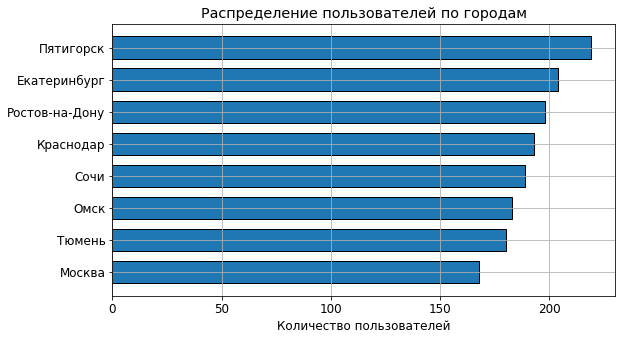

In [38]:
# Отсортируем значения, для построения диаграммы
citys = citys.sort_values(by='users')
# Создаём фигуру и оси
fig, ax = plt.subplots(figsize=(9,5))
# Наносим сетку, подписываем оси

ax.grid()
ax.set(title='Распределение пользователей по городам', 
       xlabel='Количество пользователей')
# Отрисосываем графики
ax.barh(citys.index, citys['users'], linewidth=1.0, edgecolor='k', height=0.7)
plt.show()

Частоты встречаемости представленных в выборке городов отличается не очень сильно. В выборке представлено больше всего пользователей из Пятигорска (14.28%), а меньше всего из Москвы (10.95%).

Теперь посмотрим частоту встречаемости городов у пользователей с подпиской и без неё:

In [40]:
# Создаём сводную таблицу по городам b типу подписки
citys_info = users.pivot_table(index=['city', 'subscription'], 
                               values='user_id', 
                               aggfunc='count')
# Меняем название столбца не более логичное и переустанавливаем индексы
citys_info = citys_info.rename(columns={'user_id': 'users'})
citys_info = citys_info.reset_index()
# Добавляем столбец с общим количеством пользователей
citys_info = citys_info.merge(citys, how='left', on='city', suffixes=['', '_total'])
# Разделяем датафрейм на два по наличию подписки
citys_sub = citys_info.query('subscription == True')
citys_nosub = citys_info.query('subscription == False')
# Переустанавливаем индексы
citys_sub = citys_sub.reset_index()
citys_nosub = citys_nosub.reset_index()
# Сортируем столбцы по суммарному коли-ву пользователей в городе
citys_sub = citys_sub.sort_values(by='users_total', ascending=False)
citys_nosub = citys_nosub.sort_values(by='users_total', ascending=False)
# Посчитаем долю пользователей
citys_sub['sub_ratio'] = round(citys_sub['users'] / citys_sub['users_total'] * 100, 2)
citys_nosub['nosub_ratio'] = round(citys_nosub['users'] / citys_nosub['users_total'] * 100, 2)
citys_sub

,index,city,subscription,users,users_total,proportion,sub_ratio
4,9,Пятигорск,True,94,219,14.28,42.92
0,1,Екатеринбург,True,92,204,13.30,45.10
5,11,Ростов-на-Дону,True,89,198,12.91,44.95
1,3,Краснодар,True,81,193,12.58,41.97
6,13,Сочи,True,86,189,12.32,45.50
3,7,Омск,True,91,183,11.93,49.73
7,15,Тюмень,True,82,180,11.73,45.56
2,5,Москва,True,84,168,10.95,50.00


In [41]:
citys_nosub

,index,city,subscription,users,users_total,proportion,nosub_ratio
4,8,Пятигорск,False,125,219,14.28,57.08
0,0,Екатеринбург,False,112,204,13.30,54.90
5,10,Ростов-на-Дону,False,109,198,12.91,55.05
1,2,Краснодар,False,112,193,12.58,58.03
6,12,Сочи,False,103,189,12.32,54.50
3,6,Омск,False,92,183,11.93,50.27
7,14,Тюмень,False,98,180,11.73,54.44
2,4,Москва,False,84,168,10.95,50.00


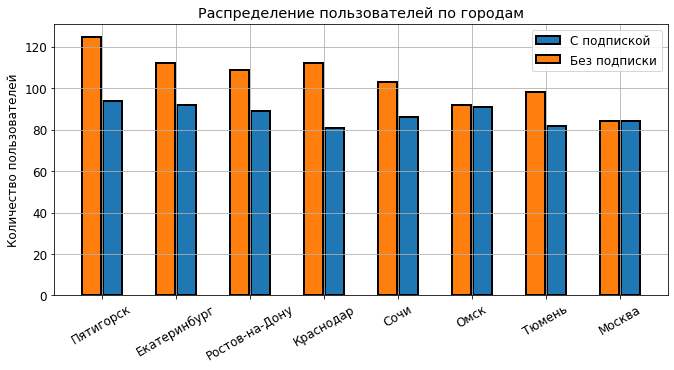

['Пятигорск', 'Екатеринбург', 'Ростов-на-Дону', 'Краснодар', 'Сочи', 'Омск', 'Тюмень', 'Москва']


In [76]:
# Создаём числовую ось x, и массив с подписью оси x
ax_x = np.arange(len(citys))
labels_x = citys_sub['city'].to_list()
# Создаём фигуру и оси
fig, ax = plt.subplots(1, 1, figsize=(11, 5))
# Отрисосываем графики
ax.bar(ax_x + 0.14, citys_sub['users'], linewidth=2.0, edgecolor='k', width=0.26, label='С подпиской')
ax.bar(ax_x - 0.14, citys_nosub['users'], linewidth=2.0, edgecolor='k', width=0.26, label='Без подписки')
ax.set(title='Распределение пользователей по городам', 
       ylabel='Количество пользователей')
ax.set_xticks(ax_x)
ax.set_xticklabels(labels_x, rotation = 30)
ax.grid()
ax.legend()
plt.show()

**Вывод:**
- в Москве и в Омске пользователей с подпиской и без неё примерно одинаковое количество
- в Пятигорске и Краснодаре максимальная доля пользователей без подписки (57% и 58% соответственно)
- в остальных городах доля пользователей без подписки составляет около 55%

#### Соотношение пользователей с подпиской и без подписки

In [43]:
# Создаём сводную таблицу по пользователям с подпиской и без неё
sub_users = users.pivot_table(index='subscription', values='user_id', aggfunc='count')
# Меняем название колонки на более логичное
sub_users = sub_users.rename(columns={'user_id': 'users'})
# Меняем название индексов на более репрезентативное
sub_users.index = ['Без подписки', 'С подпиской']

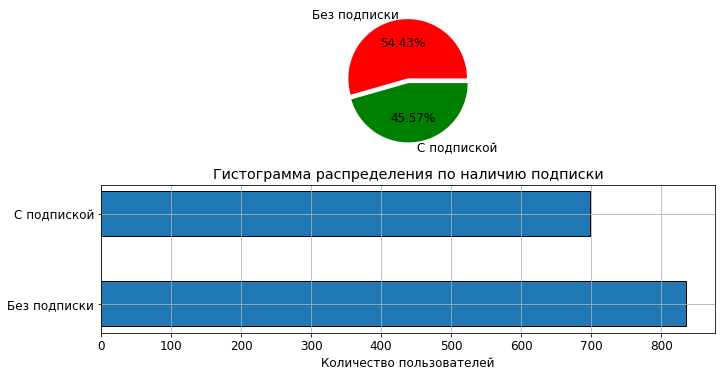

In [44]:
# Создаём фигуру и оси
fig, axs = plt.subplots(2, 1, figsize=(11, 6))
# Наносим сетку, подписываем оси
axs[1].grid()
axs[1].set(title='Гистограмма распределения по наличию подписки', 
           xlabel='Количество пользователей')
# Отрисосываем графики
axs[0].pie(sub_users['users'], 
           labels=sub_users.index, 
           autopct='%1.2f%%', 
           explode=([0.04] * 2), 
           colors=['red', 'green'])
axs[1].barh(sub_users.index, sub_users['users'], linewidth=1.0, edgecolor='k', height=0.5)
plt.show()

Пользователей без подписки немного меньше, чем пользоветелей с подпиской.

#### Возраст пользователей

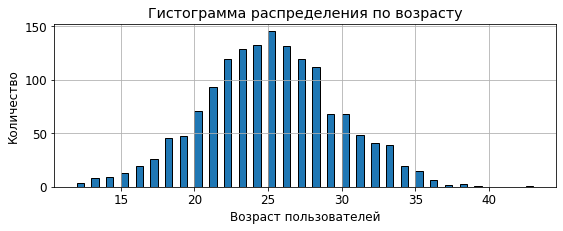

In [45]:
# Посчитаем возрастной диапазон пользователей
age_range = users['age'].max() - users['age'].min()
# Подписываем оси
plt.title('Гистограмма распределения по возрасту')
plt.xlabel('Возраст пользователей')
plt.ylabel('Количество')
# Построим гистограмму распределения
users['age'].hist(bins=age_range*2, linewidth=1.0, edgecolor='k')
plt.show()

Возраст пользователей имеет нормальное распределение. Минимальный возраст - 12 лет, максимальный - 43 года.

#### Расстояние, которое пользователь преодолел за одну поездку

Построим гистограмму распределения:

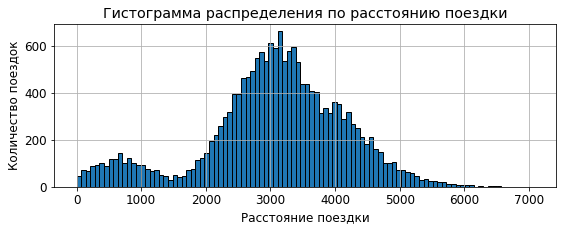

In [46]:
# Подписываем оси
plt.title('Гистограмма распределения по расстоянию поездки')
plt.xlabel('Расстояние поездки')
plt.ylabel('Количество поездок')
# Построим гистограмму распределения
rides['distance'].hist(bins=100, linewidth=1.0, edgecolor='k')
plt.show()

На гистограмме присутствует два пика, примерно на 500 и на 3000 метров. Возможно это связанно с тем, что в датафрейме представлены как крупные, так и небольшие города. Или пользователи с платной подпиской и без неё обычно перемещаются на разные расстояния. 

Проверим данные предположения. Для начала добавим в датафрейм rides столбцы city и subscription по ключу user_ud:

In [47]:
# Добавим столбец с городом в таблицу rides по ключу user_id
rides = rides.merge(users[['user_id', 'city', 'subscription']], how='left', on='user_id', suffixes=False)
rides.sample()

,user_id,distance,duration,date,speed,month,city,subscription
219,23,2827,21,2021-08-26,8.35,8,Сочи,True


Построим отдельные гистограммы для каждого города:

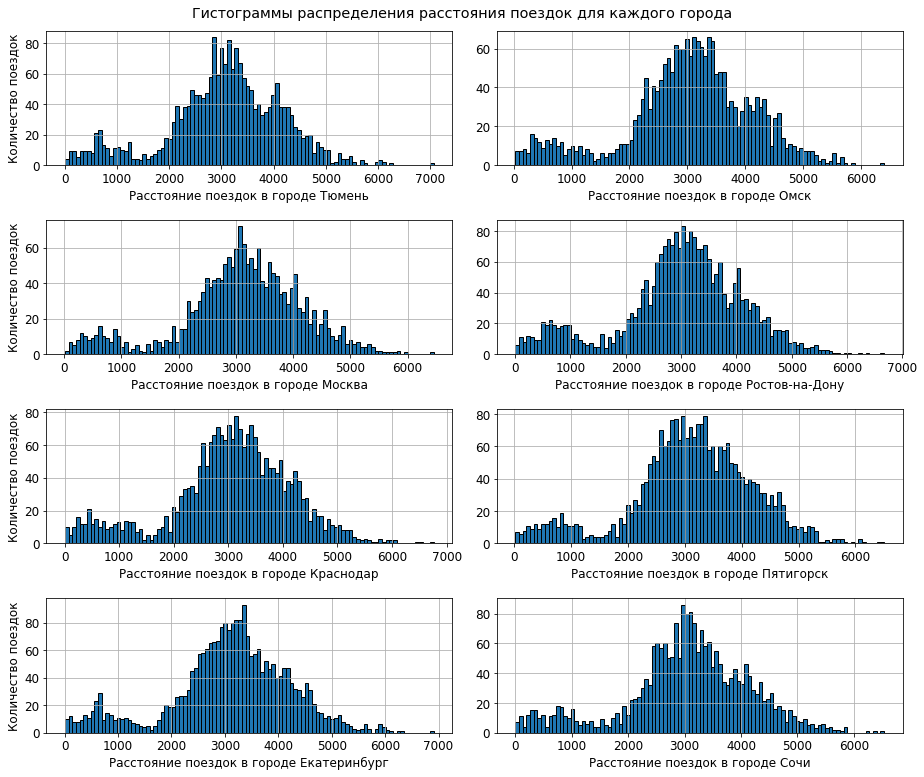

In [48]:
# Создаём список с названиями всех городов
city_names =  rides['city'].unique().tolist()
# Создаём фигуру и оси
fig, axs = plt.subplots(4, 2, figsize=(13, 11))
fig.suptitle('Гистограммы распределения расстояния поездок для каждого города')
axs = axs.flat
for city in enumerate(city_names):
    # Создаём переменные для удобства
    number = city[0]
    name = city[1]
    values = rides[rides['city'] == name]['distance']
    x_label = 'Расстояние поездок в городе ' + name
    # Добавляем строчку, что бы не перекрывались подписи осей
    plt.tight_layout()
    # Наносим сетку, подписываем оси
    axs[number].grid()
    axs[number].set(xlabel=x_label)
    if number % 2 == 0:
        axs[number].set(ylabel='Количество поездок')
    # Отрисосываем графики
    axs[number].hist(values, bins=100, linewidth=1.0, edgecolor='k')
plt.show()

Предположение о том, что длина поездки сильно зависит от города не подтвердилось: Во всех городах расстояния, на которые  пользователи перемещаются за одну поездку, примерно одинаковые.

Построим гистограммы для пользователей с подпиской и без неё:

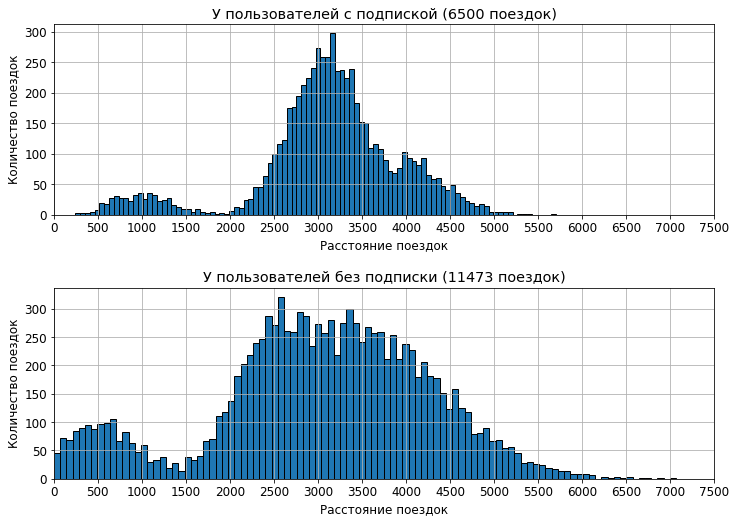

In [49]:
# Создаём фигуру и оси
fig, axs = plt.subplots(2, 1, figsize=(11, 8))
# Создаём переменные для удобства
with_sub = rides[rides['subscription']]['distance']
no_sub = rides[~rides['subscription']]['distance']
# Добавляем строчку, что бы не перекрывались подписи осей
plt.tight_layout(pad=4.0)
# Наносим сетку, подписываем оси, задаём интервалы по осям
axs[0].grid()
axs[0].title.set_text(f'У пользователей с подпиской ({len(with_sub)} поездок)', )
axs[0].set(xlabel='Расстояние поездок', ylabel='Количество поездок', 
           xticks=range(0, 8000, 500), xlim=(0, 7500))
axs[1].grid()
axs[1].title.set_text(f'У пользователей без подписки ({len(no_sub)} поездок)')
axs[1].set(xlabel='Расстояние поездок', ylabel='Количество поездок', 
           xticks=range(0, 8000, 500), xlim=(0, 7500))
# Отрисосываем графики
axs[0].hist(with_sub, bins=100, linewidth=1.0, edgecolor='k')
axs[1].hist(no_sub, bins=100, linewidth=1.0, edgecolor='k')
plt.show()

Распределение поездок у пользователей с подпиской и без подписки выглядит похоже - на обеих гистограммах присутствует по два пика.

**Вывод:** Все поездки можно условно разделить на короткие и длинные, распределение похоже на бимодальное.

#### Продолжительность поездок

Построим гистограмму распределения:

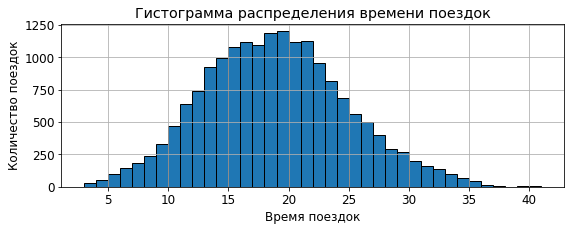

In [50]:
# Подписываем оси
plt.title('Гистограмма распределения времени поездок')
plt.xlabel('Время поездок')
plt.ylabel('Количество поездок')
# Построим гистограмму распределения
bins_rides = rides['duration'].max() - rides['duration'].min()
rides['duration'].hist(bins=bins_rides, linewidth=1.0, edgecolor='k')
plt.show()

Время поездок имеет нормальное распределение.

#### Среднее количество поездок у пользователей

Посчитаем среднее количество поездок у пользователей с подпиской и без неё:

In [51]:
# Считаем среднее количество поездок для пользователдей с подпиской и без нее
freq_rides = rides.pivot_table(index='user_id', values='subscription', aggfunc=['sum', 'count'])
freq_rides.columns=['sub', 'rides']
freq_rides['sub'] = freq_rides['sub'].astype(bool)
sub_users_rides_mean = freq_rides['rides'][freq_rides['sub']].mean()
no_sub_users_rides_mean = freq_rides['rides'][~freq_rides['sub']].mean()
print(f'Среднее количество поездок у пользователей с подпиской: {sub_users_rides_mean:.2f}')
print(f'Среднее количество поездок у пользователей без подписки: {no_sub_users_rides_mean:.2f}')

Среднее количество поездок у пользователей с подпиской: 9.30
Среднее количество поездок у пользователей без подписки: 13.74


Странный факт: пользователи с подпиской ездят реже, чем пользователи без подписки.

### Объединение данных

#### Объединение датафреймов в один

Создадим общий датафрейм, включающий в себя все данные.

In [52]:
# Объединим датафреймы rides и users в новый датафрейм data
data = rides.merge(users[['user_id', 'name', 'age']], how='left', on='user_id')
# Проверка на наличие пропусков
print(data.isna().sum().sum())
data.sample()

0


,user_id,distance,duration,date,speed,month,city,subscription,name,age
13966,1247,2521,20,2021-04-15,7.63,4,Омск,False,Марат,30


In [53]:
# Добавим в датафрейм data информацию о подписке из датафрейма subs
data = data.merge(subs, how='left', on='subscription')
# Проверка на наличие пропусков
print(data.isna().sum().sum())
data.sample()

0


,user_id,distance,duration,date,speed,month,city,subscription,name,age,minute_price,start_ride_price,subscription_fee
13070,1185,5041,20,2021-03-06,15.82,3,Ростов-на-Дону,False,Александр,20,8,50,0


Разделим датафрейм на два:
- пользователи с подпиской
- пользователи без подписки

In [54]:
# Разделим общий датафрейм на два (с подпиской и без неё)
df_subs = data[data['subscription']]
df_nosubs = data[~data['subscription']]
# Проверка созданных датафреймов на пропуски и соразмерность
print(df_subs.isna().sum().sum())
print(df_nosubs.isna().sum().sum())
print(len(df_subs) + len(df_nosubs) == len(data))

0
0
True


In [55]:
# Проверим датафрейм df_subs
df_subs.sample()

,user_id,distance,duration,date,speed,month,city,subscription,name,age,minute_price,start_ride_price,subscription_fee
5725,612,3961,16,2021-01-30,15.32,1,Ростов-на-Дону,True,Елена,32,6,0,199


In [56]:
# Проверим датафрейм df_nosubs
df_nosubs.sample()

,user_id,distance,duration,date,speed,month,city,subscription,name,age,minute_price,start_ride_price,subscription_fee
8976,886,1942,12,2021-07-05,10.29,7,Тюмень,False,Наташа,22,8,50,0


Все датафреймы, необходимые для дальнейшено анализа, были успешно созданы.

#### Визуализация времени для двух категорий пользователей

Построим гистограммы распределения для пользователей с подпиской и без неё:

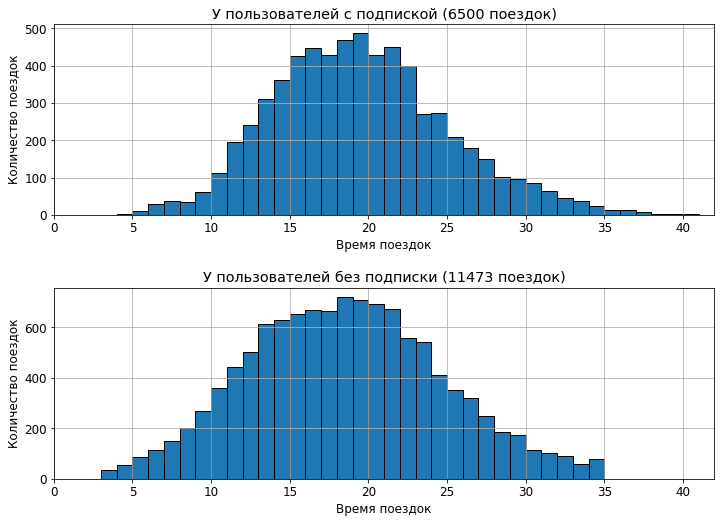

In [57]:
# Рассчитаем оптимальное количество корзин
bins_sub = df_subs['duration'].max() - df_subs['duration'].min()
bins_nosub = df_nosubs['duration'].max() - df_nosubs['duration'].min()
# Рассчитаем максимум по оси x
max_x = max(df_subs['duration'].max(), df_nosubs['duration'].max()) + 1

# Создаём фигуру и оси
fig, axs = plt.subplots(2, 1, figsize=(11, 8))
# Добавляем строчку, что бы не перекрывались подписи осей
plt.tight_layout(pad=4.0)
# Наносим сетку, подписываем оси, задаём интервалы по осям
axs[0].grid()
axs[0].title.set_text(f'У пользователей с подпиской ({len(df_subs)} поездок)', )
axs[0].set(xlabel='Время поездок', ylabel='Количество поездок', 
           xticks=range(0, max_x, 5), xlim=(0, max_x))
axs[1].grid()
axs[1].title.set_text(f'У пользователей без подписки ({len(df_nosubs)} поездок)')
axs[1].set(xlabel='Время поездок', ylabel='Количество поездок', 
           xticks=range(0, max_x, 5), xlim=(0, max_x))
# Отрисосываем графики
axs[0].hist(df_subs['duration'], bins=bins_sub, linewidth=1.0, edgecolor='k')
axs[1].hist(df_nosubs['duration'], bins=bins_nosub, linewidth=1.0, edgecolor='k')
plt.show()

In [58]:
# Посмотрим среднее и отклонение
print('Для пользователей с подпиской')
print(f"Среднее значение: {df_subs['duration'].mean():.0f}")
print(f"Стандартное отклонение: {df_subs['duration'].std():.0f}")
print()
print('Для пользователей без подписки')
print(f"Среднее значение: {df_nosubs['duration'].mean():.0f}")
print(f"Стандартное отклонение: {df_nosubs['duration'].std():.0f}")

Для пользователей с подпиской
Среднее значение: 19
Стандартное отклонение: 6

Для пользователей без подписки
Среднее значение: 18
Стандартное отклонение: 6


**Выводы:**

Графики похожи, на обоих графиках обображено нормальное распределение. У пользователей без подписки чуть меньше среднее время поездки, и этом чуть больше стандартное отклонение.

#### Визуализация расстояния для двух категорий пользователей

Построим гистограммы распределения для пользователей с подпиской и без неё:

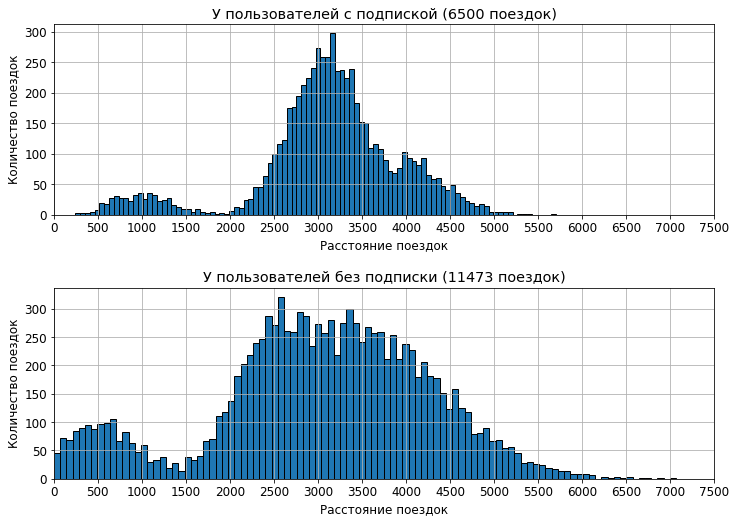

In [59]:
# Создаём фигуру и оси
fig, axs = plt.subplots(2, 1, figsize=(11, 8))
# Добавляем строчку, что бы не перекрывались подписи осей
plt.tight_layout(pad=4.0)
# Наносим сетку, подписываем оси, задаём интервалы по осям
axs[0].grid()
axs[0].title.set_text(f'У пользователей с подпиской ({len(df_subs)} поездок)', )
axs[0].set(xlabel='Расстояние поездок', ylabel='Количество поездок', 
           xticks=range(0, 8000, 500), xlim=(0, 7500))
axs[1].grid()
axs[1].title.set_text(f'У пользователей без подписки ({len(df_nosubs)} поездок)')
axs[1].set(xlabel='Расстояние поездок', ylabel='Количество поездок', 
           xticks=range(0, 8000, 500), xlim=(0, 7500))
# Отрисосываем графики
axs[0].hist(df_subs['distance'], bins=100, linewidth=1.0, edgecolor='k')
axs[1].hist(df_nosubs['distance'], bins=100, linewidth=1.0, edgecolor='k')
plt.show()

Для большей наглядности, построим гистограммы на одном графике.

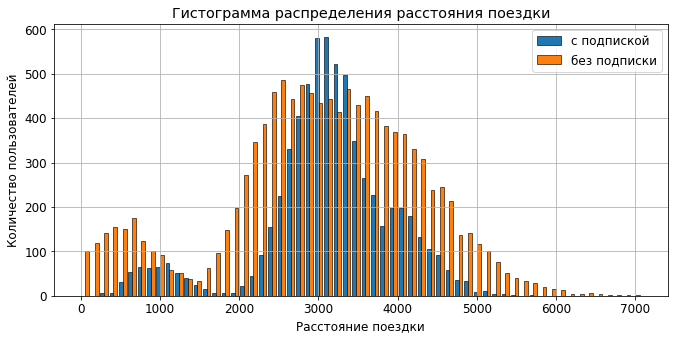

In [60]:
# Создаём фигуру и оси
fig, ax = plt.subplots(figsize=(11, 5))
# Отрисосываем графики
ax.hist([df_subs['distance'], df_nosubs['distance']], 
        linewidth=0.6, 
        edgecolor='k',
        bins=60, 
        label=['с подпиской', 'без подписки'])
ax.set(title='Гистограмма распределения расстояния поездки', 
       xlabel='Расстояние поездки',
       ylabel='Количество пользователей')
ax.legend()
ax.grid()
plt.show()

In [61]:
# Посмотрим среднее и отклонение
print('Для пользователей с подпиской')
print(f"Среднее значение: {df_subs['distance'].mean():.0f}")
print(f"Стандартное отклонение: {df_subs['distance'].std():.0f}")
print()
print('Для пользователей без подписки')
print(f"Среднее значение: {df_nosubs['distance'].mean():.0f}")
print(f"Стандартное отклонение: {df_nosubs['distance'].std():.0f}")

Для пользователей с подпиской
Среднее значение: 3115
Стандартное отклонение: 837

Для пользователей без подписки
Среднее значение: 3028
Стандартное отклонение: 1236


**Выводы:**
- Гистограммы распределения имеют похожую форму.
- У пользователей без подписки много коротких поездок (до 500 метров), а у пользователей с подпиской их почти нет. Возможно это связано с тем, что пользователи без подписки тестировали сервис.
- Также у пользователей без подписки доля поездок далее чем на 3.5 км. больше (на верхней гистограмме после 3.5 км. идёт резкий спад).
- Стандартное отклонение у пользователей без подписки значительно выше (у пользоветелей с подпиской поездки расположены кучнее, основная масса поездок была в пределах примерно 2.5 - 3.5 км.)

### Подсчёт выручки

Создадим новый датафрейм с агрегированными данными о поездках по месяцам и посчитаем выручку каждого пользователя за каждый месяц.

In [62]:
# Создаём сводную таблицу
df_income = data.pivot_table(index=['user_id', 'month'], 
                             values=['distance', 'duration', 
                                     'subscription',
                                     'minute_price', 'start_ride_price', 'subscription_fee'], 
                             aggfunc={'distance': 'sum',
                                      'duration': ['sum', 'count'],
                                      'minute_price': 'median',
                                      'start_ride_price': 'median',
                                      'subscription_fee': 'median', 
                                      'subscription': 'median'})
# Меняем названия столбцов на более удобные
df_income.columns=['distance', 'rides', 'duration', 'minute_price', 'start_price', 'subscription', 'sub_price']
# Создаём новый столбей с выручкой
df_income['income'] = (df_income['duration'] * df_income['minute_price'] +
                       df_income['rides'] * df_income['start_price'] +
                       df_income['sub_price'])
df_income.head(10)

distance  rides  duration  minute_price  start_price  \
user_id month                                                         
1       1          7028      2        42             6            0   
        4           754      1         7             6            0   
        8          6724      2        46             6            0   
        10         5810      2        32             6            0   
        11         7004      3        56             6            0   
        12         6752      2        28             6            0   
2       3         10188      3        63             6            0   
        4          6165      2        40             6            0   
        6          3255      1        14             6            0   
        7          6781      2        48             6            0   

               subscription  sub_price  income  
user_id month                                   
1       1              True        199     451  
        4              True        199     241  
        8              True        199     475  
        10             True        199     391  
        11             True        199     535  
        12             True        199     367  
2       3              True        199     577  
        4              True        199     439  
        6              True        199     283  
        7              True        199     487

In [63]:
# Код ревьюера
df_income.groupby('subscription')['income'].mean()

subscription
False    329.332644
True     362.792191
Name: income, dtype: float64

### Проверка гипотез

#### Тратят ли пользователи с подпиской больше времени на поездки

**Нулевая гипотеза:** Пользователи с подпиской и без подписки тратят одинаковое количество времени на поездки.

**Альтернативная гипотеза:** Пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки.

In [64]:
# Задаём минимальную вероятность получить такую выборку, при условии, что гипотеза верна
alpha = 0.01
# Передаём в метод имеющиеся выборки и необходимые настройки
results = st.ttest_ind(df_subs['duration'], df_nosubs['duration'], 
                       equal_var=False, 
                       alternative='greater')
# Выводим на экран p-значение
print('p-значение:', results.pvalue)
# Сравниваем p-значение с alpha и делаем вывод
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-значение: 3.086332092684639e-29
Отвергаем нулевую гипотезу


**Вывод:** 

Скорее всего, пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки.

#### Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров

**Нулевая гипотеза:** Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку равно 3130 метров.

**Альтернативная гипотеза:** Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, больше 3130 метров.

In [65]:
# Задаём минимальную вероятность получить такую выборку, при условии, что гипотеза верна
alpha = 0.01
# Передаём в метод имеющиеся выборки и необходимые настройки
results = st.ttest_1samp(df_subs['distance'], 3130, alternative='greater')
# Выводим на экран p-значение
print('p-значение:', results.pvalue)
# Сравниваем p-значение с alpha и делаем вывод
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-значение: 0.9195649894697724
Не отвергаем нулевую гипотезу


**Вывод:** Нет оснований счиать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку не превышает оптимальное с точки зрения износа самоката (3130 м.).

#### Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки

Создадим два списка:
- все месячные выручки всех пользователей с подпиской
- все месячные выручки всех пользователей без подписки

In [66]:
# Создаём списки с месячными выручками для пользователей с подпиской и без 
sub = df_income['income'][df_income['subscription']]
no_sub = df_income['income'][~df_income['subscription']]

Для начала, визуализируем данные на гистограммах:

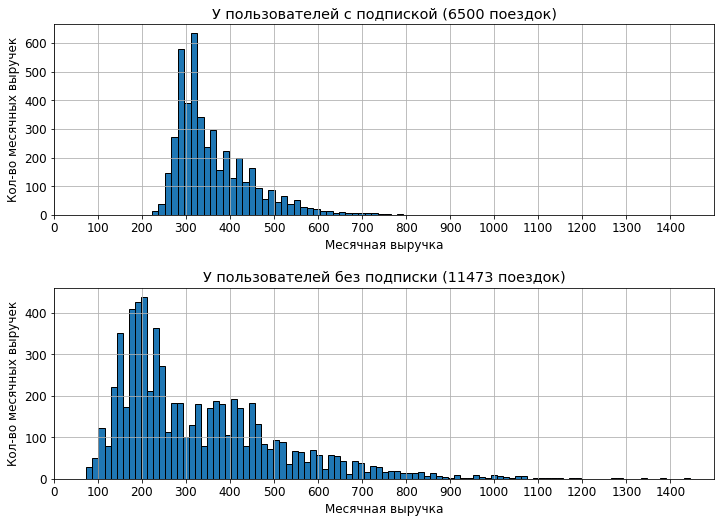

In [67]:
# Создаём фигуру и оси
fig, axs = plt.subplots(2, 1, figsize=(11, 8))
# Добавляем строчку, что бы не перекрывались подписи осей
plt.tight_layout(pad=4.0)
# Наносим сетку, подписываем оси, задаём интервалы по осям
axs[0].grid()
axs[0].title.set_text(f'У пользователей с подпиской ({len(df_subs)} поездок)', )
axs[0].set(xlabel='Месячная выручка', ylabel='Кол-во месячных выручек', 
           xticks=range(0, 1500, 100), xlim=(0, 1500))
axs[1].grid()
axs[1].title.set_text(f'У пользователей без подписки ({len(df_nosubs)} поездок)')
axs[1].set(xlabel='Месячная выручка', ylabel='Кол-во месячных выручек', 
           xticks=range(0, 1500, 100), xlim=(0, 1500))
# Отрисосываем графики
axs[0].hist(sub, bins=50, linewidth=1.0, edgecolor='k')
axs[1].hist(no_sub, bins=100, linewidth=1.0, edgecolor='k')
plt.show()

In [68]:
# Посмотрим среднее и отклонение
print('Для пользователей с подпиской')
print(f"Среднее значение: {sub.mean():.0f}")
print(f"Стандартное отклонение: {sub.std():.0f}")
print()
print('Для пользователей без подписки')
print(f"Среднее значение: {no_sub.mean():.0f}")
print(f"Стандартное отклонение: {no_sub.std():.0f}")

Для пользователей с подпиской
Среднее значение: 363
Стандартное отклонение: 88

Для пользователей без подписки
Среднее значение: 329
Стандартное отклонение: 183


Дисперсия у пользователей без подписки значительно выше, из-за этого сложно однозначно сделать какой-либо вывод.

Сформулируем гипотезы и проведём тест.

**Нулевая гипотеза:** Помесячная выручка от пользователей с подпиской и без подписки одинаковая.

**Альтернативная гипотеза:** Помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки.

In [69]:
# Задаём минимальную вероятность получить такую выборку, при условии, что гипотеза верна
alpha = 0.01
# Передаём в метод имеющиеся выборки и необходимые настройки
results = st.ttest_ind(sub, no_sub, 
                       equal_var=False, 
                       alternative='greater')
# Выводим на экран p-значение
print('p-значение:', results.pvalue)
# Сравниваем p-значение с alpha и делаем вывод
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-значение: 2.4970242872858465e-38
Отвергаем нулевую гипотезу


**Вывод:** Скорее всего помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки.

#### Ответ на вопрос, касающийся обновления сервера

**Вопрос:**

Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

**Ответ:**

Для проверки данной гипотезы понадобится провести тест ttest_rel() библиотеки scipy.stats, с оргументом alternative='greater':

from scipy import stats as st
results = st.ttest_rel(before, after, alternative='less')

Гипотезы будут сформулированы следующим образом:
- Нулевая гипотеза: Количестве обращений до и после обновления не изменилось.
- Альтернативная гипотеза: Количестве обращений после обновления снизилось.

Поскольку, техническую команду интересуют только значимые изменения, возьмём коэффициент alpha = 0.01, ближе к нижней границе, тогда сравнение будет выглядеть следующим образом:

if results.pvalue < alpha:
    
    print('Отвергаем нулевую гипотезу')

else:
    
    print('Не отвергаем нулевую гипотезу')

В случае, если нулевая гипотеза будет отвергнута, будут основания считать, что верна альтернативная - т.е. что количество обращений снизилось.

### Рассчёты распределений

#### Рассчёт количества промокодов

**Постановка задачи:**

Отделу маркетинга поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж.

Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10% пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5%. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

**Построение графика:**

Построим график зависимости вероятности получить 100 поьзователей, продливших подписку от общего числа разосланных промокодов:

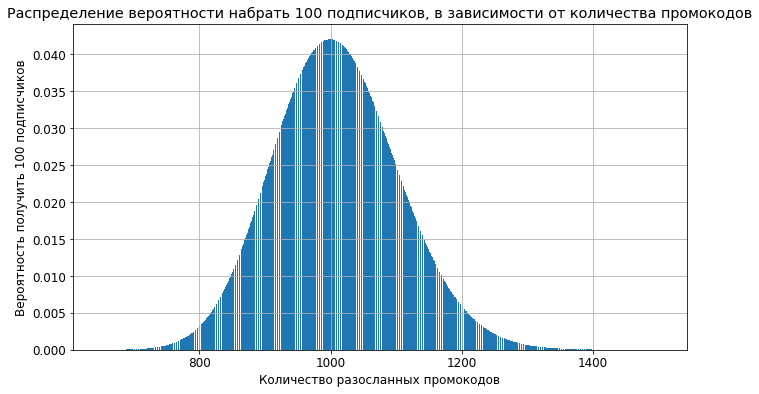

In [70]:
# Задаём примерное кол-во разосланных промокодов, 
# которое точно будет больше, чем нам нужно
n = 1501
# Создаём список значений с вероятностями получить ровно 100 подписчиков, 
# в зависимости от кол-ва разосланных промокодов
distr=[]
for i in range(650, n):
    distr.append(st.binom.pmf(k=100, n=i, p=0.1))
# Строим график
plt.figure(figsize=(11, 6))
plt.title('Распределение вероятности набрать 100 подписчиков, в зависимости от количества промокодов')
plt.xlabel('Количество разосланных промокодов')
plt.ylabel('Вероятность получить 100 подписчиков')
plt.grid()
plt.bar(range(650, n), distr)
plt.show()

**Рассчёт нужного количества разосланных промоколов:**

In [71]:
#  Задаём параметры
k=100
n = 1500
alpha = 0.05
# Циклом подбираем нужное n
for i in range(n):
    p = st.binom.cdf(k=100, n=i, p=0.1)
    if st.binom.cdf(k=100, n=i, p=0.1) < alpha:
        break
print(f'Необходимое количество промокодов: {i}')

Необходимое количество промокодов: 1172


**Вывод:**

Для того что бы вероятность не выполнить план по получению 100 новых подписчиков была не более 5%, нужно разослать не менее 1172 промокодов.

#### Оценка вероятности открытия уведомлений

**Постановка задачи:**

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40% получивших клиентов. Отдел планирует разослать 1 млн. уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399.5 тыс. пользователей.

**Построение графика:**

Поскольку n (количество уведомлений) достаточно большое, а p (вероятность прочтения сообщения) близко к 0.5, мы можем аппроксимировать биномиальное распределение нормальным и построим график нормального распределения.

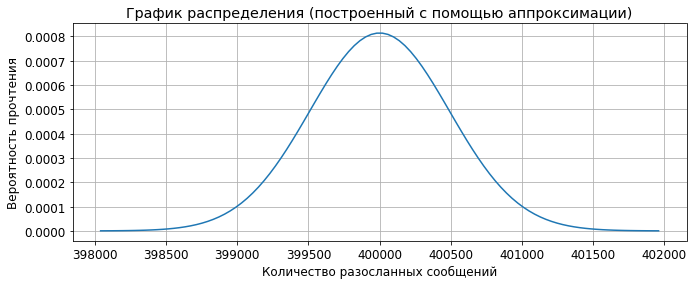

In [72]:
# Задаём параметры биномиального распределения
n = 10**6
p = 0.4

# Зададим мат.ожидание и ст.отклонение нормального распределения равными
# мат.ожиданию и ст.отклонению биномиального распределения
mu = n * p
sigma = (n * p * (1 - p)) ** 0.5

# Задаём нормальное распределение по параметрам
distr = st.norm(mu, sigma)

# Создаём диапазон для оси x
x_array = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)

# ПОтрисовываем график
plt.figure(figsize=(11, 4))
plt.title('График распределения (построенный с помощью аппроксимации)')
plt.xlabel('Количество разосланных сообщений')
plt.ylabel('Вероятность прочтения')
plt.grid()
plt.plot(x_array, st.norm.pdf(x_array, mu, sigma))
plt.show()

In [73]:
value = 399500
# считаем вероятность хвоста слева от 43 тысяч
result = distr.cdf(value)
print(f'Вероятность: {result:.2%}')

Вероятность: 15.37%


**Вывод:**

Вероятность того, что уведомления откроют не более 399.500 пользователей (при 1 млн. разосланных уведомлений) равна 15.37%.

### Общий вывод

**Выводы:**

1. В 95-ти поездках были выявлены аномально низкие значения времени. Скорее всего плата за эти поездки была начислена некорректно. Рекомендую передать информацию в техническую поддержку для проверки и устранения неполадок.

2. Средний возраст пользователей от 20-ти до 30-ти лет. Таргетированную рекламу лучше настраивать на эту возрастную категорию.

3. Можно сделать вывод, что пользователи с подпиской предпочтительнее, потому что:
    - помесячная выручка от пользователей с подпиской выше
    - среднее расстояние, которое проезжают пользователи с подпиской за одну поездку не превышает оптимальное с точки зрения износа самоката

4. В Москве и Омске доля пользователей с платной подпиский максимальная (около 50%), в то время, как в Пятигорске и Краснодаре она минимальная (43% и 42% соответственно). Увеличивать долю платных подписок лучше начинать с этих городов, т.к. потенциал для роста там больше.

**Ответы на вопросы:**

1. Для того что бы вероятность не выполнить план по получению 100 новых подписчиков была не более 5%, нужно разослать не менее 1172 промокодов.
2. Вероятность того, что уведомления откроют не более 399.500 пользователей (при 1 млн. разосланных уведомлений) равна 15.37%.

